### Step 1: Import Required Libraries
This code block imports the necessary libraries and modules required for data preprocessing, feature engineering, and machine learning tasks. The libraries include:

- `pandas` and `numpy` for data manipulation and numerical computations.
- `sklearn` modules for preprocessing, pipeline creation, model building, and evaluation.
- `re` for regular expression operations.

These libraries will be used throughout the notebook for various tasks such as data cleaning, feature extraction, and building machine learning pipelines.

In [167]:
# Step 1: Import Required Libraries
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.svm import OneClassSVM
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score
import pandas as pd
import numpy as np
import re
import shap

### Step 2: Define Helper Functions
This step defines a set of helper functions that will be used for data preprocessing and feature engineering:

1. **`convert_to_binary(column, pattern)`**: Extracts binary encodings from a column based on a given regular expression pattern.
2. **`aspect_to_cardinal(aspect)`**: Converts an aspect value (in degrees) into its corresponding cardinal direction (e.g., N, NE, E, etc.).
3. **`process_avalanche_data(df)`**: Processes avalanche data by:
    - Extracting binary values for elevation and aspect.
    - Pivoting the data to create separate columns for each problem type.
    - Resetting the index to make latitude and longitude regular columns.


In [168]:
# Step 2: Define Helper Functions
def convert_to_binary(column, pattern):
    """Function to extract the binary encodings in the column."""
    return column.str.extract(pattern).fillna(0).agg(''.join, axis=1).astype(int)

def aspect_to_cardinal(aspect):
    """
    Convert aspect in degrees to cardinal direction.
    """
    if (aspect >= 337.5 or aspect < 22.5):
        return "N"
    elif (aspect >= 22.5 and aspect < 67.5):
        return "NE"
    elif (aspect >= 67.5 and aspect < 112.5):
        return "E"
    elif (aspect >= 112.5 and aspect < 157.5):
        return "SE"
    elif (aspect >= 157.5 and aspect < 202.5):
        return "S"
    elif (aspect >= 202.5 and aspect < 247.5):
        return "SW"
    elif (aspect >= 247.5 and aspect < 292.5):
        return "W"
    elif (aspect >= 292.5 and aspect < 337.5):
        return "NW"
    else:
        return "Unknown"

def process_avalanche_data(df):
    """Pivot the problems into columns and extract binary values."""
    # Extract binary values for elevation and aspect
    df['problem_elevation_binary'] = convert_to_binary(
        df['problem_elevation'], r'(\d)-(\d)-(\d)')
    df['problem_aspect_binary'] = convert_to_binary(
        df['problem_aspect'], r'(\d)-(\d)-(\d)-(\d)-(\d)-(\d)-(\d)-(\d)')

    pivoted = df.pivot_table(
        index=['lat', 'lon', 'elevation', 'forecast_region', 'start_angle', 'confidence', 'aspect', 'alp_rating', 'tln_rating', 'btl_rating'],
        columns='problem',
        values=['problem_elevation_binary',
                'problem_aspect_binary', 'size_min',
               'size_max', 'likelihood_min', 'likelihood_max'],
        aggfunc='first'
    )

    pivoted.columns = [f"{col[1]}_{col[0]}" for col in pivoted.columns]

    # Reset the index to make lat and lon regular columns
    pivoted = pivoted.reset_index()

    return pivoted

In [169]:
# Step 3: Load and Parse Data
df = pd.read_json("avalanche_merge.json", lines=True)

### Step 5: Parse Features for Easier Encoding
This step involves parsing and transforming specific features in the dataset to make them easier to encode:

1. **`size`**: Extracts the minimum and maximum size values into separate columns (`size_min` and `size_max`) and coverts to an int.
2. **`likelihood`**: Removes unnecessary suffixes and splits the likelihood range into two separate columns (`likelihood_min` and `likelihood_max`).
3. Handles missing values in `likelihood_max` by filling them with the corresponding values from `likelihood_min`.

In [170]:
# Step 5: Parse Features for Easier Encoding
df[['size_min', 'size_max']] = df['size'].str.extract(
    r'size-(\d+)-(\d+)', expand=True).astype(int)
df['likelihood'] = df['likelihood'].str.replace('_en', '')
df[['likelihood_min', 'likelihood_max']] = df['likelihood'].str.extract(
    r'likelihood-([a-zA-Z]+)(?:_([a-zA-Z]+))?'
)

df['likelihood_min'] = df['likelihood_min']
df['likelihood_max'] = df['likelihood_max'].fillna(df['likelihood_min'])


### Step 6: Process Avalanche Data
This step processes the avalanche data by pivoting problem-related columns into separate features and extracting binary encodings for elevation and aspect. The latitude and longitude columns are dropped after processing.

### Step 7: Convert Aspect to Cardinal Directions
The aspect values (in degrees) are converted into their corresponding cardinal directions (e.g., N, NE, E, etc.) for better interpretability.

### Step 8: Handle Missing Values and Convert Floats to Integers
Binary columns are converted to integers from float and missing values are replaced with 0.

In [171]:
# Step 6: Process Avalanche Data
avalanche_wrangled = process_avalanche_data(df).drop(['lat', 'lon'], axis=1)

# Step 7: Convert Aspect to Cardinal Directions
avalanche_wrangled['aspect'] = avalanche_wrangled['aspect'].apply(
    lambda x: aspect_to_cardinal(x) if isinstance(x, (int, float)) else x)

# Step 8: Handle Missing Values and Convert Floats to Integers
avalanche_wrangled[avalanche_wrangled.select_dtypes(include=['float64']).columns] = avalanche_wrangled[avalanche_wrangled.select_dtypes(
    include=['float64']).columns].fillna(0).astype(int)


likelihood_mapping = {
    'unlikely': 1,
    'possible': 2,
    'likely': 3,
    'verylikely': 4,
    'certain': 5
}

# Identify all likelihood columns
likelihood_columns = [col for col in avalanche_wrangled.columns if 'likelihood' in col]

# Apply the mapping to the likelihood columns
avalanche_wrangled[likelihood_columns] = avalanche_wrangled[likelihood_columns].replace(likelihood_mapping)


C:\Users\Admin\AppData\Local\Temp\ipykernel_4628\1787431911.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  avalanche_wrangled[likelihood_columns] = avalanche_wrangled[likelihood_columns].replace(likelihood_mapping)


### Step 9: Define Column Groups
In this step, the columns in the dataset are grouped into three categories for preprocessing:

1. **Ordinal Columns**: Columns with a predefined order, such as ratings or levels.
2. **Categorical Columns**: Columns with discrete, unordered categories.
3. **Numerical Columns**: Columns with continuous numerical values.

These groups will be used to apply specific preprocessing steps tailored to each type of data.

In [172]:
ordinal_order = {
    'alp_rating': ['low', 'moderate', 'considerable', 'high', 'extreme'],
    'tln_rating': ['low', 'moderate', 'considerable', 'high', 'extreme'],
    'btl_rating': ['norating', 'low', 'moderate', 'considerable', 'high', 'extreme'],
    'confidence': ['notdefined', 'low', 'moderate', 'high']

}


# Step 9: Define Column Groups
ordinal_columns = avalanche_wrangled[ordinal_order.keys()].columns
categorical_columns = avalanche_wrangled.select_dtypes(
    include=['object', 'category']).columns.drop(ordinal_order.keys())
numerical_columns = avalanche_wrangled.select_dtypes(
    exclude=['object', 'category']).columns


### Step 10: Define Preprocessors
This step defines preprocessors for different types of columns in the dataset:

1. **Numeric Preprocessor**: Handles missing values in numerical columns by replacing them with a constant value (e.g., 0).
2. **Ordinal Preprocessor**: Handles missing values in ordinal columns by replacing them with "unknown" and applies ordinal encoding based on predefined categories.
3. **Categorical Preprocessor**: Handles missing values in categorical columns by replacing them with "unknown" and applies one-hot encoding to convert categories into binary features.

These preprocessors are combined into a `ColumnTransformer` to apply the appropriate transformations to each column group.

In [173]:
# Step 10: Define Preprocessors
numeric_preprocessor = Pipeline(
    steps=[
        ("imputation_constant", SimpleImputer(strategy="constant", fill_value=0))
    ]
)

ordinal_preprocessor = Pipeline(
    steps=[
        ("imputation_constant", SimpleImputer(
            strategy="constant", fill_value="unknown")),
        ("ordinal", OrdinalEncoder(categories=[
         ordinal_order[col] for col in ordinal_columns]))
    ]
)

categorical_preprocessor = Pipeline(
    steps=[
        ("imputation_constant", SimpleImputer(
            strategy="constant", fill_value="unknown")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocessor, numerical_columns),
        ("ord", ordinal_preprocessor, ordinal_columns),
        ("cat", categorical_preprocessor, categorical_columns)
    ]
)


In [174]:
# Step 11: Define Pipeline
# pipeline = Pipeline(steps=[
#     # ("preprocessor", preprocessor),
#     ("isolation_forest", IsolationForest(
#         n_estimators=100, random_state=42))
# ])

pipeline = IsolationForest(n_estimators=100, random_state=42)


In [175]:
X_train, X_test = train_test_split(
    avalanche_wrangled, test_size=0.2, random_state=42)

X_train = preprocessor.fit_transform(X_train)


onehot_columns = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_columns)
all_columns = numerical_columns.tolist() + ordinal_columns.tolist() + onehot_columns.tolist()

# Convert the transformed array back to a DataFrame
transformed_df = pd.DataFrame(X_train, columns=all_columns)

aggegated_df = transformed_df.copy()

pipeline.fit(transformed_df)   



IsolationForest(random_state=42)

In [176]:

aggegated_df['anomaly'] = pipeline.predict(transformed_df)


aggegated_df['anomaly_score'] = pipeline.decision_function(transformed_df)


normal = aggegated_df[aggegated_df['anomaly'] == 1]

anomalies = aggegated_df[aggegated_df['anomaly'] == -1]






In [177]:
normal_sample = np.random.choice(normal.index,size=100,replace=False)
sample = np.append(anomalies.index,normal_sample)
print(sample)

[  3   5  24  27  30  36  54  61  65  75  76  79  92  96 111 119 135 147
 151 183 199 220 223 239 240 242 243 261 264 276 289 298 299 306 311 312
 317 320 331 336 344 355 356 359 376 409 420 436 451 466 488 520 521 522
 524 528 535 536 538 541 547 560 570 571 579 592 595 610 615 628 639 642
 648 655 657 658 665 693 705 716 752 773 776 778 782 783  53 418 107 781
 222 116 612   4 473 190 337 491 794 439  12 619 205 540 614 468  66 719
 374  62 765  50  81 548  48 369 126 406 139 434 259 624 481 683 585 733
 367 214 133 446 392 229 644 271  47 395 738 155  31 640 388 497 268  67
 286 189 670 515 164 318 632 241  90 711 475 324 233 412 630 501 246  39
 200 159 496 384 650 584 652 459 230 572 750  63  52 432  15 263 563 553
 495 482  37 633 138 568]


In [178]:

# explainer = shap.Explainer(pipeline.decision_function, transformed_df)


# shap_values = explainer(transformed_df.iloc[normal_sample])

explainer = shap.TreeExplainer(pipeline)
shap_values = explainer(transformed_df)

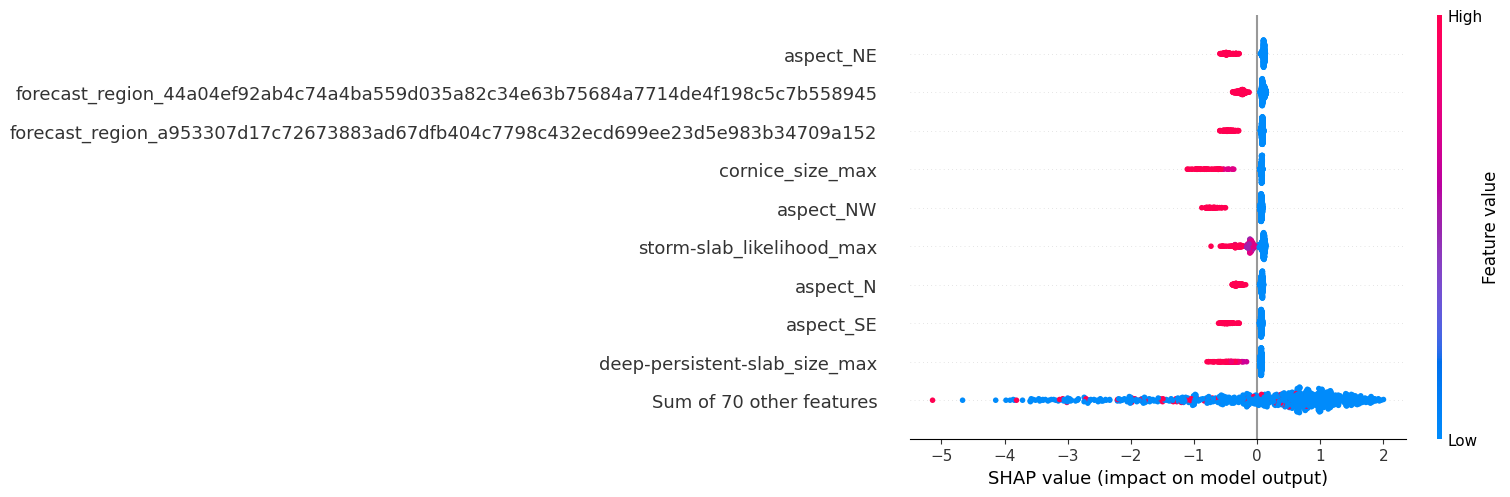

In [181]:
shap.plots.beeswarm(shap_values)
